In [8]:
import wandb
api = wandb.Api()


In [24]:
from pathlib import Path
import json
import pandas as pd
import re

# algo_mapping = {
#     "0sds7bw5": "CQL",
#     "z64aipi0": "$\delta$ = 1",
#     "i87w77ty": "$\delta$ = 2",
#     "ft6049mq": "$\delta$ = $\delta_\max$",
# }
algo_mapping = {
    "cql": "CQL",
    "4x3-test": "$\delta$ = 1",
    "delta-2": "$\delta$ = 2",
    "baseline": "$\delta$ = $\delta_\max$",
}

source_ts_amounts= [n * 2048 * 2 for n in [4, 8, 6]]
source_ts = 'data timesteps'
algo = 'algorithm'

def generate():
    for path in Path('artifacts').rglob('*.json'):
        # Extract run_id and id_within_run
        _, name, *_ = path.parts
        run_id_match = re.search(r"run-([a-z0-9]+)", name)
        id_within_run_match = re.search(r"_([0-9]+)-", name)

        if run_id_match:
            run_id = run_id_match.group(1)
        else:
            run_id = None

        if id_within_run_match:
            id_within_sweep = id_within_run_match.group(1)
            run_id = f'{run_id}_{id_within_sweep}'
            id_within_sweep = int(id_within_sweep)
        else:
            id_within_sweep = 2

        with path.open() as f:
            table = json.load(f)
        df = pd.DataFrame(table['data'], columns=table['columns'])
        source_ts_amount = source_ts_amounts[id_within_sweep]


        print(name, run_id, id_within_sweep, source_ts_amount)

        config = api.run(f"rldl/icvi/{run_id}").config
        print(run_id, config)
        try:
            config_name = config['config']
        except KeyError:
            config_name = config['config_name']
        df[algo] = algo_mapping[config_name]

        df[source_ts] = source_ts_amount
        yield df
        
df = pd.concat(list(generate()), ignore_index=True)

x = 'timestep'
y = 'discounted returns'

df = df.rename(columns={'returns': y})
df.loc[:, x] = df.groupby(['idx', algo, source_ts, 'step'])[x].cumsum()
def keep_last_n_steps(group, n=10):
    steps = sorted(group['step'].unique())
    top_n = steps[-n:]
    return group[group['step'].isin(top_n)]

df = df.groupby([algo, source_ts], group_keys=False).apply(keep_last_n_steps)
df = df.sort_values(by=[algo, source_ts, 'step', 'idx', x])

bin_size = 20
df[x] = (df[x] // bin_size ) * bin_size
df = df[df[x] < 800]
df[source_ts].unique()

run-ft6049mq-tablereturns:v15 ft6049mq 2 24576
ft6049mq {'lr': 0.0005, 'seed': 1, 'gamma': 0.99, 'config': 'baseline', 'n_plot': 3, 'env_args': {'n_objects': 4, 'n_sequence': 2, 'n_permutations': 6, 'permutation_starting_idx': 6}, 'env_name': 'SEQUENCE', 'ppo_args': {'lr': 0.0003, 'env_args': {'n_objects': 4, 'n_sequence': 2, 'n_permutations': 6, 'permutation_starting_idx': 0}, 'num_steps': 2048, 'agent_args': {'recurrent': False, 'hidden_size': 64}, 'gae_lambda': 0.95, 'disable_gae': False, 'num_updates': 6, 'update_args': {'ppo_epoch': 10, 'clip_param': 0.2, 'entropy_coef': 0, 'max_grad_norm': 0.5, 'num_mini_batch': 2, 'value_loss_coef': 0.5}, 'log_interval': 25, 'dummy_vec_env': True, 'num_processes': 6, 'save_interval': 50, 'use_replay_buffer': True, 'disable_linear_lr_decay': False, 'disable_proper_time_limits': False}, 'load_path': None, 'test_size': 20, 'model_args': {'n_heads': 8, 'n_hidden': 256, 'n_layers': 3, 'n_rotations': 2, 'conservative_loss_coef': None, 'positional_enco

array([16384, 24576, 32768])

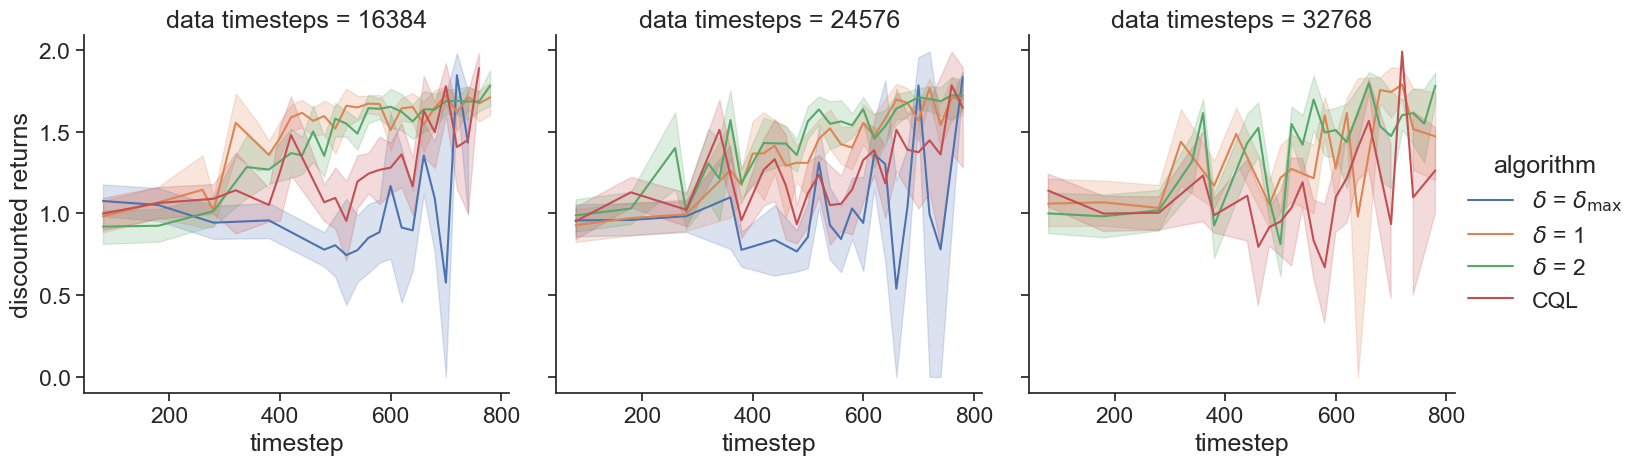

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.reset_defaults()
sns.set(font_scale=1.5)
sns.set_style('ticks')

g = sns.relplot(x=x, y=y, kind='line', hue=algo, data=df, col=source_ts)
plt.show()